# Проект. Машинное обучение для текстов

## Проект для «Викишоп»

**Описание проекта**
* Интернет-магазин «Викишоп» запускает новый сервис. 
* Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. 
* То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
* Обучите модель классифицировать комментарии на позитивные и негативные. 
* В вашем распоряжении набор данных с разметкой о токсичности правок.

* Постройте модель со значением метрики качества **F1** не меньше **0.75**. 

**План работы**
* **Загрузка и подготовка данных**
* **Обучение**
* **Тестирование¶**
* **Вывод**

## Загрузка и подготовка данных

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import lightgbm as lgb


import nltk
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\copok\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\copok\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS


tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))

In [3]:
pth1 = 'C:/Users/copok/Documents/Проекты/Яндекс практикум/13 Проект для «Викишоп»/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=0)
elif os.path.exists(pth2):
    df= pd.read_csv(pth2, index_col=0)
else:
    print('Something is wrong')

In [4]:
def get_data_info(data):
    display(data.sample(5))
    print('-'*50)
    display(data.info()) 
    print('-'*50)
    print('Количество дубликатов:', sum(data.duplicated()))

In [5]:
get_data_info(df)

,text,toxic
29141,Certified...? \n\nCertified.Crybaby sounds mor...,0
56008,You fake bastard. This site is a fraud!,1
151174,"""\n\n baiting Paul \n\nI don't think its entir...",0
59011,you're a dick. feel free to delete my wikipedi...,1
2561,duplicate\ncheck this out Image:Liakhoff.JPG a...,0


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

--------------------------------------------------
Количество дубликатов: 0


In [6]:
print("0:",df[df.toxic==0]['text'].count())
print("1:",df[df.toxic==1]['text'].count())

0: 143106
1: 16186


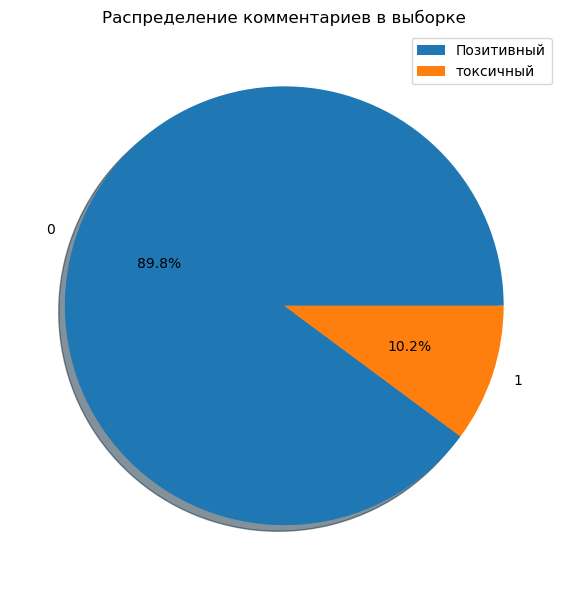

In [7]:
df.toxic.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, figsize=(8,6))
plt.legend(['Позитивный','токсичный'])
plt.title('Распределение комментариев в выборке')
plt.tight_layout()
plt.axis('off');

* Видим, что у нас Позитивных комментариев больше, чем токсичных. 
* Так же помним, что комментарии были выгружены с какими-то спец.символами и числами. 
* Очистим их с помощью регулярных выражений и лемматизируем.

In [8]:
# инициализируем Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [9]:
# напишем функцию для pos-тегов - маркировки частей речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [10]:
# напишем функцию для очистки и лемматизации текста с маркированными частями речи
def clear_text(text):
    reg = re.sub(r'[^a-zA-Z]', ' ', text)
    clear = reg.split() 
    lemm = []
    # в цикле лемматизируем очищенный текст
    for i in range(len(clear)):
        lemm.append(lemmatizer.lemmatize(clear[i], get_wordnet_pos(clear[i])))
    return " ".join(lemm)

In [11]:
%%time
df['lemm_text'] = df['text'].apply(clear_text)

CPU times: total: 56min 9s
Wall time: 56min 35s


In [12]:
df

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not try to edit war It s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...
...,...,...,...
159446,""":::::And for the second time of asking, when ...",0,And for the second time of ask when your view ...
159447,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That be a ho...
159448,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm there no actual article for prosti...
159449,And it looks like it was actually you who put ...,0,And it look like it be actually you who put on...


In [18]:
df['lemm_text']

0         Explanation Why the edits make under my userna...
1         D aww He match this background colour I m seem...
2         Hey man I m really not try to edit war It s ju...
3         More I can t make any real suggestion on impro...
4         You sir be my hero Any chance you remember wha...
                                ...                        
159446    And for the second time of ask when your view ...
159447    You should be ashamed of yourself That be a ho...
159448    Spitzer Umm there no actual article for prosti...
159449    And it look like it be actually you who put on...
159450    And I really don t think you understand I come...
Name: lemm_text, Length: 159292, dtype: object

Разделим датасет на тестовую и тренировочную выборку

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('toxic', axis=1),
    df['toxic'],
    test_size=0.2,
    random_state=12345,
    stratify=df['toxic'] # стратифицируем текст, чтобы выборки были более сбалансированы
)

# вытаскиваем корпусы
corpus_train = X_train['lemm_text']
corpus_test = X_test['lemm_text']
corpus_train

4627      I don t mean to intrude but I have notice the ...
23562     God or whoever whatever I now decree you the c...
128516    Can we keep this neat and sequential We have a...
31151     Here s what you say May Rama block expires Jun...
41257     Sir Giggsy have often say that he like to keep...
                                ...                        
54776     Indeed BigDunc that page rightly say that para...
75640     I m not try to make a point or anything except...
71266     Forgive my cruddy formattingI m still relative...
55812     Talk Grasshopper Scouts I move your comment fr...
11556                                  Oppose WP COMMONNAME
Name: lemm_text, Length: 127433, dtype: object

In [20]:
print(f"Размер тренировочного корпуса: {len(corpus_train)}")
print(f"Размер тестого корпуса: {len(corpus_test)}")

Размер тренировочного корпуса: 127433
Размер тестого корпуса: 31859


**TF-IDF**

In [21]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\copok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
count_tf_idf = TfidfVectorizer(stop_words=list(STOP_WORDS))    # подгружаем счетчик и задаём стоп-слова
tf_idf_train = count_tf_idf.fit_transform(corpus_train) # обучаем и трансформируем
tf_idf_test = count_tf_idf.transform(corpus_test)       # трансформируем тестовую без обучения

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (127433, 139857)
Размер матрицы: (31859, 139857)


Обработка данных выполнена, TF-IDF подсчитано, можно приступить к обучению модели:

## Обучение

### LogisticRegression

In [29]:
parm_LR = {
    "penalty": ['l1', 'l2'],
    "class_weight": ['balanced', 'none'],
}

LR_model = LogisticRegression(random_state=12345, max_iter=1000)

In [30]:
%%time
LR_model = RandomizedSearchCV(estimator = LR_model, param_distributions = parm_LR,\
                              scoring='f1', n_jobs=-1,cv=4, verbose=2).fit(tf_idf_train, y_train)
print(LR_model.best_params_)
print(LR_model.best_score_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'penalty': 'l2', 'class_weight': 'balanced'}
0.7453514258464415
CPU times: total: 25.5 s
Wall time: 21.3 s


In [31]:
%%time
LR_pred_train = LR_model.predict(tf_idf_train)

CPU times: total: 15.6 ms
Wall time: 16.2 ms


In [32]:
%%time
f1_train_lr = f1_score(y_train, LR_pred_train)
f"F1 для LogisticRegression на обучающей выборке: {round(f1_train_lr, 2)}"

CPU times: total: 188 ms
Wall time: 47.3 ms


'F1 для LogisticRegression на обучающей выборке: 0.83'

### DecisionTreeClassifier

In [33]:
parm_DT = {
    "max_depth": range(2, 20)
}

DT_model = DecisionTreeClassifier(random_state=12345)

In [34]:
%%time
DT_model = RandomizedSearchCV(estimator = DT_model, param_distributions=parm_DT,\
                              scoring='f1', n_jobs=-1,cv=4, verbose=2).fit(tf_idf_train, y_train)
print(DT_model.best_params_)
print(DT_model.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
{'max_depth': 19}
0.6463243594605205
CPU times: total: 24.3 s
Wall time: 5min 6s


In [35]:
%%time
DT_pred_train = DT_model.predict(tf_idf_train)

CPU times: total: 156 ms
Wall time: 163 ms


In [36]:
%%time
f1_train_dt = f1_score(y_train, DT_pred_train)
f"F1 для DecisionTreeClassifier на обучающей выборке: {round(f1_train_dt, 2)}"

CPU times: total: 62.5 ms
Wall time: 52.6 ms


'F1 для DecisionTreeClassifier на обучающей выборке: 0.7'

### lightgbm

In [37]:
param_lgbm = {
    'max_depth': [15, 30],
    'learning_rate': [0.1, 0.3]
}

lgbm_model = lgb.LGBMClassifier(random_state=12345, boosting_type='gbdt', n_jobs=-1)

In [38]:
%%time
lgbm_model = RandomizedSearchCV(estimator =lgbm_model, param_distributions=param_lgbm,\
                              scoring='f1', n_jobs=-1,cv=4, verbose=2).fit(tf_idf_train, y_train)
print(lgbm_model.best_params_)
print(lgbm_model.best_score_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'max_depth': 30, 'learning_rate': 0.3}
0.7610308992700657
CPU times: total: 2min 18s
Wall time: 3min 31s


In [39]:
%%time
lgbm_pred_train = lgbm_model.predict(tf_idf_train)

CPU times: total: 6.25 s
Wall time: 893 ms


In [40]:
%%time
f1_train_lgbm = f1_score(y_train, lgbm_pred_train)
f"F1 для LGBMClassifier на обучающей выборке: {round(f1_train_lgbm, 2)}"

CPU times: total: 250 ms
Wall time: 62.4 ms


'F1 для LGBMClassifier на обучающей выборке: 0.85'

**Посмотрим на результат**

In [41]:
model = pd.DataFrame([
                      ['LogisticRegression', round(LR_model.best_score_, 2), round(f1_train_lr, 2)],
                      ['DecisionTree', round(DT_model.best_score_, 2), round(f1_train_dt, 2)],
                      ['lightgbm', round(lgbm_model.best_score_, 2), round(f1_train_lgbm, 2)]],
                    columns = ['model', 'F1_model', 'F1_train'])

In [42]:
model

,model,F1_model,F1_train
0,LogisticRegression,0.75,0.83
1,DecisionTree,0.65,0.70
2,lightgbm,0.76,0.85


* Исходя из полученных значений метрики **`F1`**
* Лучший результат метрики **`F1`** у **`lightgbm`** модели как просто у модели так и на тренировочной выборке 
* Проведем тестирование

## Тестирование

In [43]:
%%time
test_pred_lgbm = lgbm_model.predict(tf_idf_test)

CPU times: total: 1.77 s
Wall time: 254 ms


In [44]:
test_f1 =f1_score(y_test,test_pred_lgbm )
f"F1 для тестовой выборке: {round(test_f1 , 2)}"

'F1 для тестовой выборке: 0.77'

## Вывод

* Загрузили данные
* Выполнили  очистку данные с помощью регулярных выражений и лемматизиро.
* Выполнили  лемматизацию.
* Спомощью **`TF-IDF`** убрали стоп слава и создали мешки.
* Провели обучение разных моделей
* Лучшая модель **`lgb.LGBMClassifier`** значение F1 на тестовой выборки **`0.85`**
* Провели тестирование
  * Получили результа **`F1`** = **0.77**
* **Условие задания Вполнено 0.75 < 0.77**  